In [1]:
fname = '/mnt/archive/Antonio/data/usALEX/2017-06-11/002_12d_tit2_D190uW_A80uW.hdf5'        

In [2]:
from pathlib import Path

In [3]:
fname = Path(fname)

In [4]:
mlabel = '{}_{}'.format(fname.parts[-2], fname.stem[:7])
mlabel

'2017-06-11_002_12d'

In [5]:
assert fname.is_file(), 'File not found.'

# Imports

In [6]:
import os
import numpy as np
from IPython.display import display, HTML
import pandas as pd
import matplotlib as mpl
mpl.rcParams['font.sans-serif'].insert(0, 'Arial')
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
import lmfit; lmfit.__version__

'0.9.6'

In [8]:
import phconvert; phconvert.__version__

'0.7.3+49.g4dcb7b4'

In [9]:
%config InlineBackend.figure_format = 'retina'

In [10]:
from fretbursts import *

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.6.4+59.gc97d4a8).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [11]:
sns = init_notebook(apionly=True)

In [12]:
def info_html(d):
    wl_d, wl_a =  d.setup['excitation_wavelengths']*1e9
    Dex, Aex = d.setup['excitation_input_powers']*1e3
    Dex_str, Aex_str = '%.0fmW' % Dex, '%.0fmW' % Aex
    if Dex < 1:
        Dex_str, Aex_str = '%.0fμW' % (Dex*1e3), '%.0fμW' % (Aex*1e3)   
    s = """
    <h3>File: &nbsp; &nbsp; &nbsp; {fname}</h3>
    <blockquote><p class="lead">{descr}</p></blockquote>
    <ul>
    <li><span style='display: inline-block; width: 150px;'>Acquisition duration:</span> {time:.1f} s </li>
    <li><span style='display: inline-block; width: 150px;'>Laser power:</span>   <b>{Dex_str}</b>  @ {wl_d:.0f}nm &nbsp;&nbsp;&nbsp; <b>{Aex_str}</b> @ {wl_a:.0f}nm </li>
    <li><span style='display: inline-block; width: 150px;'>ALEX period [offset]: </span> {period} ({period_us:.1f} μs)  [{offset}] </li></ul>
    """.format(fname=fname, time=float(d.acquisition_duration), Dex_str=Dex_str, Aex_str=Aex_str, 
               period=d.alex_period, period_us=d.alex_period*d.clk_p*1e6, offset=d.offset,
               descr=d.description.decode(), wl_d=wl_d, wl_a=wl_a)
    return HTML(s)

In [13]:
import json

def cal_phrate(d, stream, phrates=None, recompute=False):
    if phrates is None:
        phrates = {}
    phrates_fname = Path('results/%s_phrate_%s.csv' % (mlabel, stream))
    phrates_fnameB = Path('results/%s_phrate_%sB.csv' % (mlabel, stream))
    if phrates_fname.is_file() and not recompute:
        with open(phrates_fname) as f:
            phrates[str(stream)] = json.load(f)
        phr = pd.read_csv(phrates_fnameB, index_col=0)
        phr.columns = [int(c) for c in phr.columns]
        phr.columns.name = 'spot'
        phrates[str(stream)+'B'] = phr
    else:
        try:
            print('stream %s compact' % str(stream))
            d.calc_max_rate(m=10, ph_sel=stream, compact=True)
        except ValueError:
            d.calc_max_rate(m=10, ph_sel=stream, compact=False)
        phrates[str(stream)+'B'] = make_df_bursts(d.max_rate)
        phrates[str(stream)] = {
                        'num_bursts': int(d.num_bursts),
                        'num_nans': int(np.isnan(d.max_rate[0]).sum())}
        phrates[str(stream)]['num_valid'] = int(d.num_bursts - phrates[str(stream)]['num_nans'])
        phrates[str(stream)]['valid_fraction'] = float(100 * phrates[str(stream)]['num_valid'] / d.num_bursts)

        phrates_fname.parent.mkdir(parents=True, exist_ok=True)
        with open(phrates_fname, 'wt') as f:
            json.dump(phrates[str(stream)], f)
        phrates[str(stream)+'B'].to_csv(phrates_fnameB)

    print('   Valid fraction (mean of all ch): %.1f %%' %
          np.mean(phrates[str(stream)]['valid_fraction']))
    return phrates

def make_df_bursts(list_of_columns):
    ncols = len(list_of_columns)
    nrows = max(len(x) for x in list_of_columns)
    columns = np.arange(ncols)
    df = pd.DataFrame(columns=columns, index=np.arange(nrows), dtype=float)
    df.columns.name = 'spot'
    for col, col_data in zip(columns, list_of_columns):
        df.iloc[:len(col_data), col] = col_data
    return df

In [14]:
save_figures = True
savefigdir_ = 'figures'

def save_name(name, folder='.', nospaces=False):
    sname = '%s/%s_%s' % (folder, mlabel, name)
    if nospaces:
        sname = sname.replace(' ', '_')
    return sname 
    
def savefig(name, nospaces=True, **kwargs):
    if not save_figures:
        return
    kwargs_ = dict(dpi=300, bbox_inches='tight')
                   #frameon=True, facecolor='white', transparent=False)
    kwargs_.update(kwargs)
    fname = save_name(name, savefigdir_, nospaces=nospaces)
    plt.savefig(fname, **kwargs_)
    print('Saved: %s.png' % fname, flush=True)

# Load the selected file

We can finally load the data and store it in a variable called `d`:

In [15]:
d = loader.photon_hdf5(fname)

In [16]:
info_html(d)

In [17]:
# d = loader.usalex(fname)
# d.add(det_donor_accept = (0, 1), 
#       alex_period = 4000,
#       offset = 2700,
#       A_ON = (2120, 3920), D_ON = (120, 1920),
#       #D_ON = (2180, 3900), A_ON = (200, 1800),
#      )

In [18]:
# #d = loader.usalex(fname)
# d.add(det_donor_accept = (0, 1), 
#       alex_period = 4000,
#       offset = 700,
#       #D_ON = (2120, 3920), A_ON = (120, 1920),
#       D_ON = (2180, 3900), A_ON = (200, 1800),
#      )

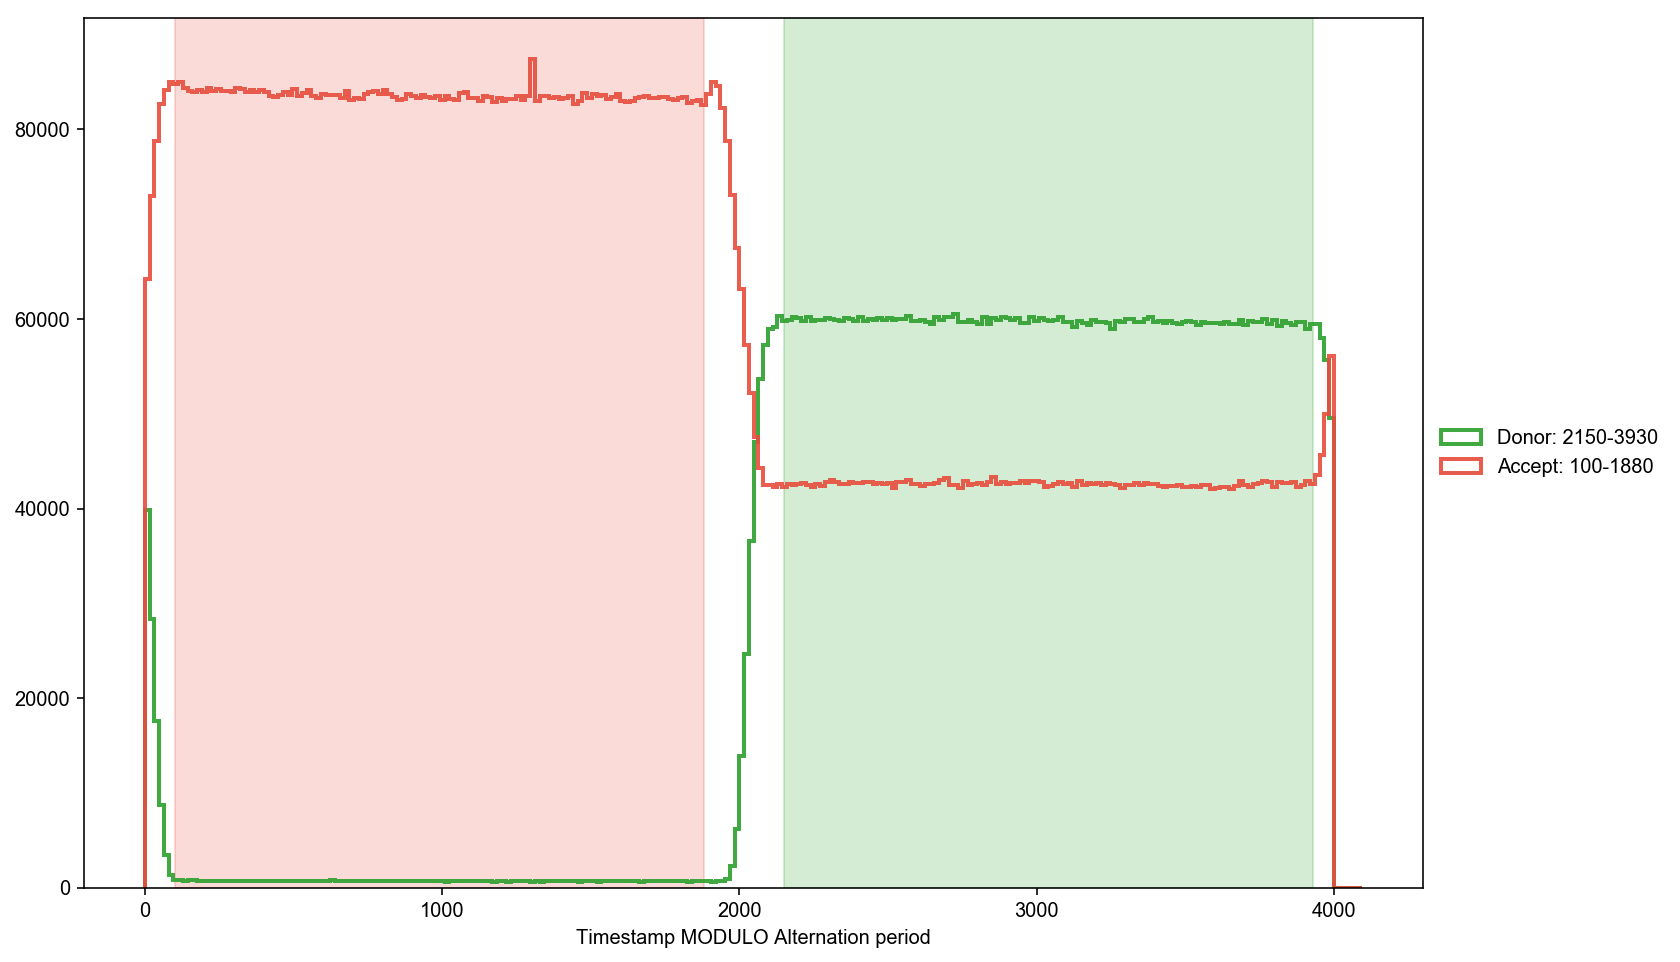

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))
bpl.plot_alternation_hist_usalex(d, ax=ax, bins=np.arange(0, 4097, 16))

If the previous alternation histogram looks correct, 
the corresponding definitions of the excitation periods can be applied to the data using the following command:

In [20]:
loader.alex_apply_period(d)

# Total photons (after ALEX selection):    20,767,423
#  D  photons in D+A excitation periods:    6,729,304
#  A  photons in D+A excitation periods:   14,038,119
# D+A photons in  D  excitation period:    11,390,341
# D+A photons in  A  excitation period:     9,377,082



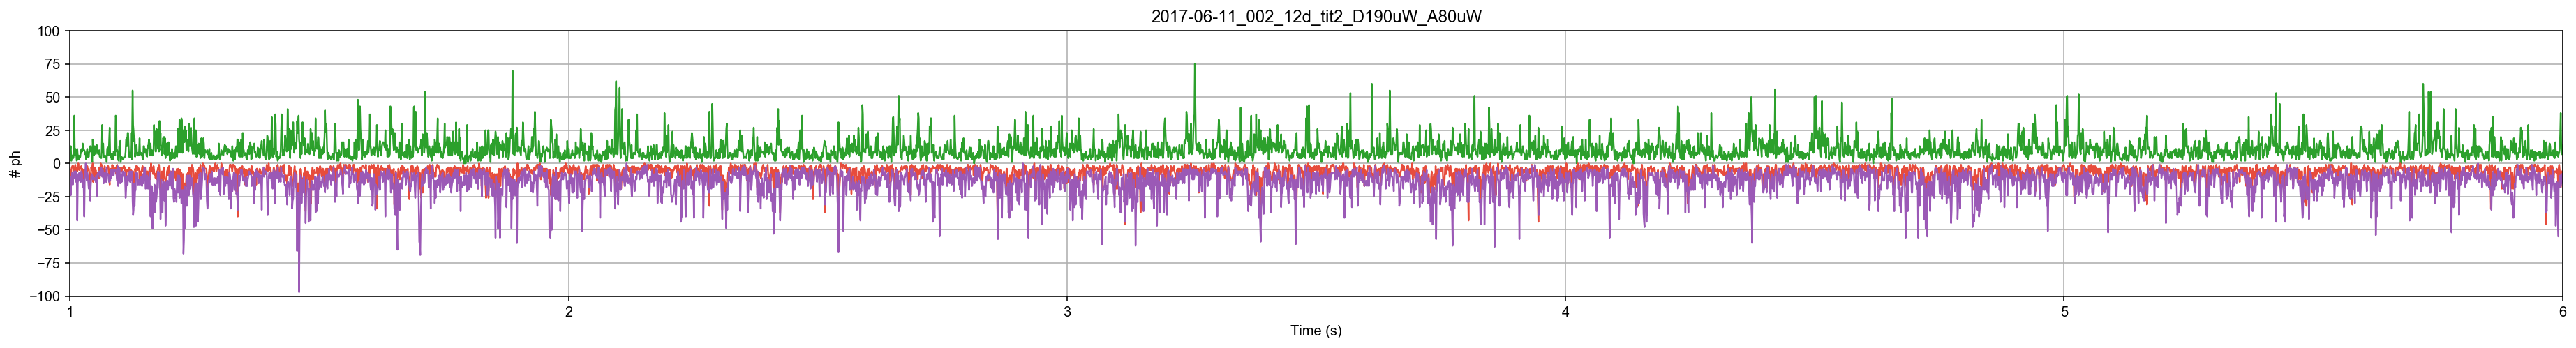

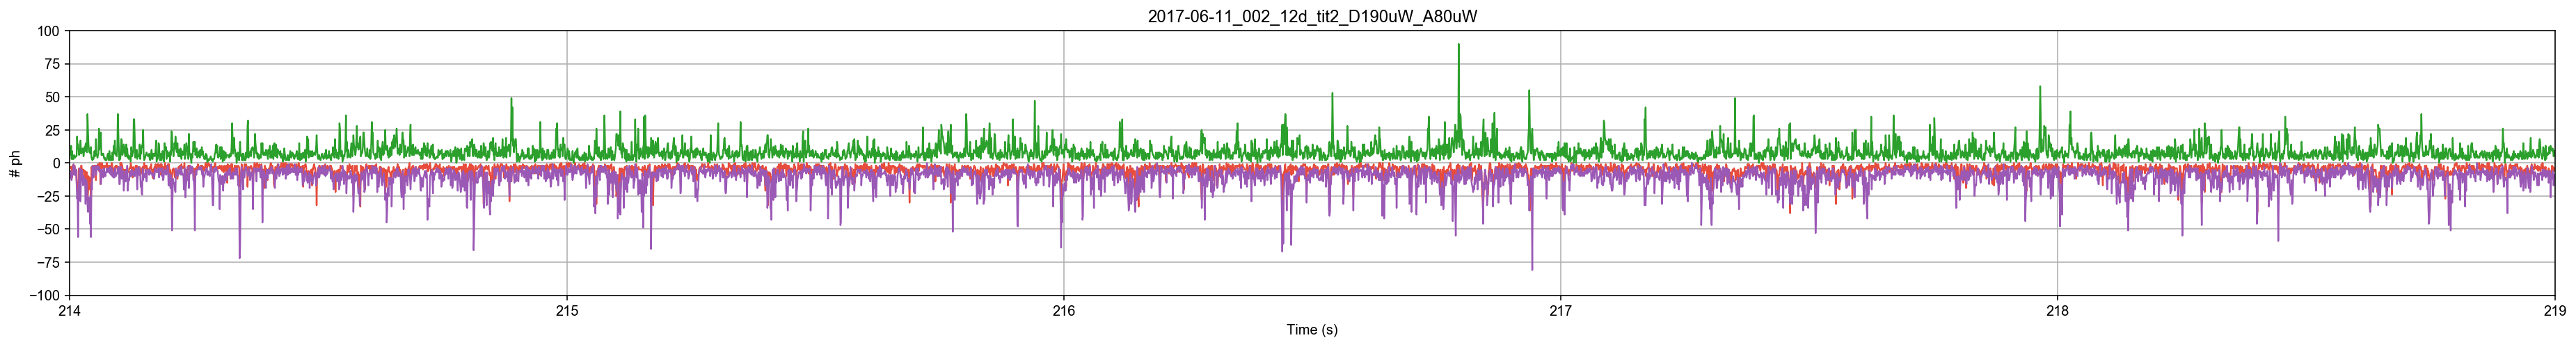

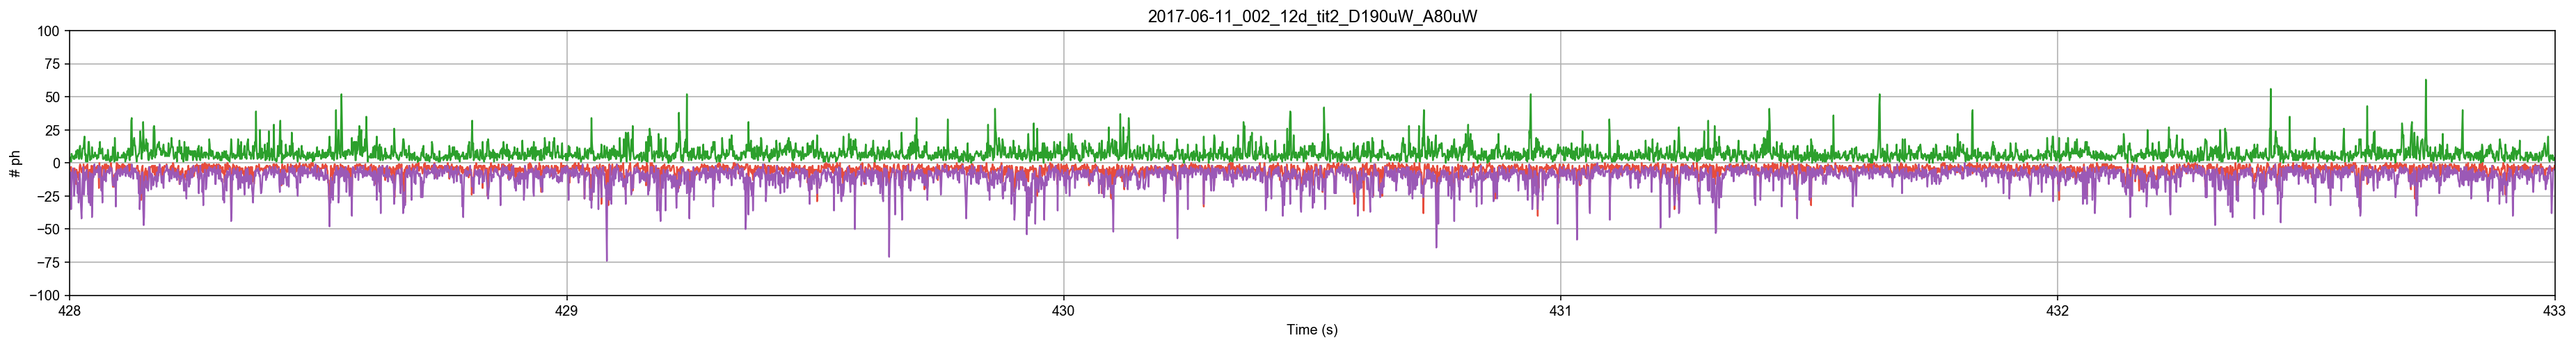

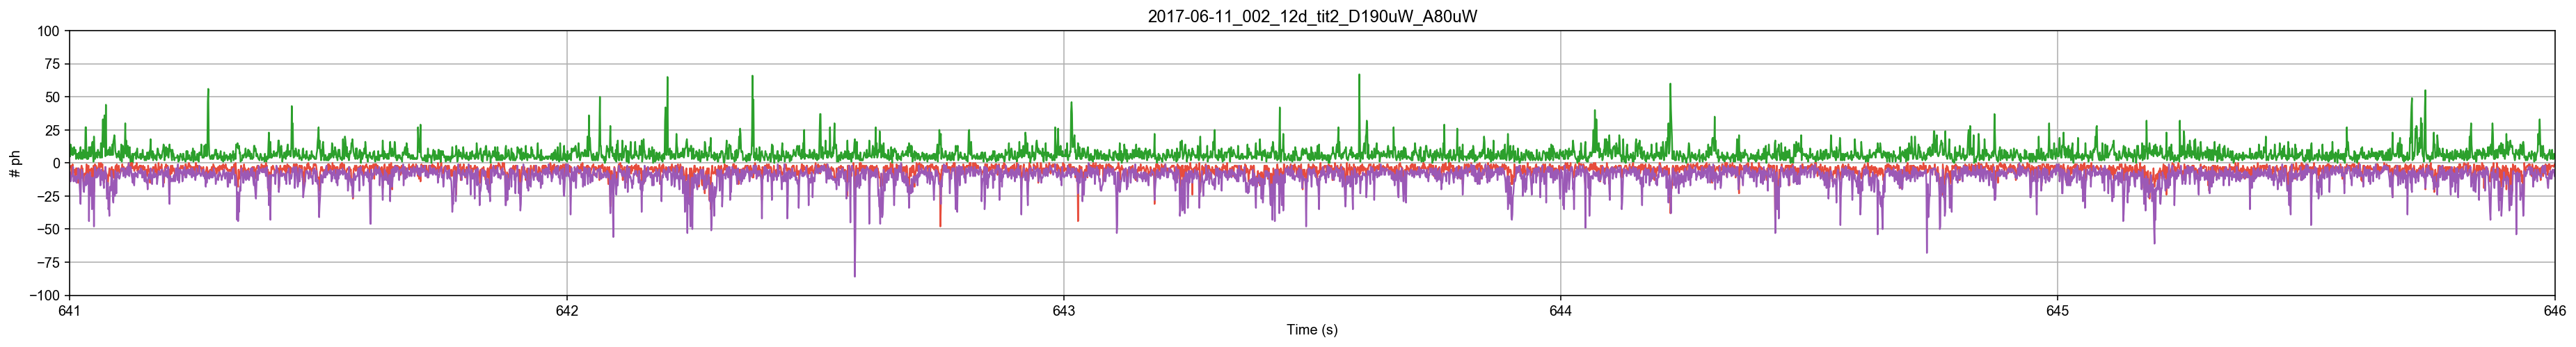

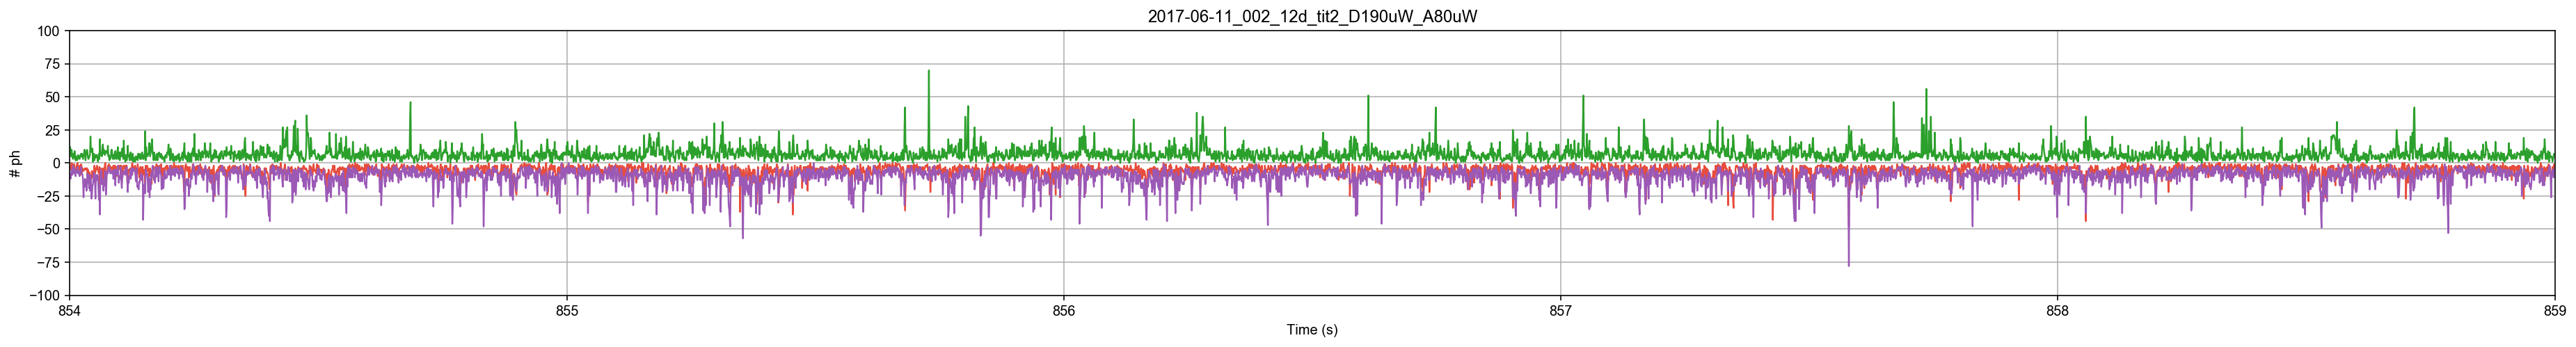

In [21]:
num_time_points = 5
window = 5

# Timepoints equally distributed along the measurement
time_points = np.round(np.linspace(d.time_min+1, d.time_max-window-1, num=num_time_points))

for i in time_points:
    dplot(d, timetrace, tmin=i, tmax=i+window, figsize=(32, 3.5));
    plt.ylim(-100, 100)
    plt.xlim(i, i+window)
    #savefig("%s_timetrace_t=%d-%d.png" % (mlabel, i, i+1))

In [22]:
d.calc_bg(bg.exp_fit, time_s=10, tail_min_us='auto', F_bg=1)

 - Calculating BG rates ... [DONE]


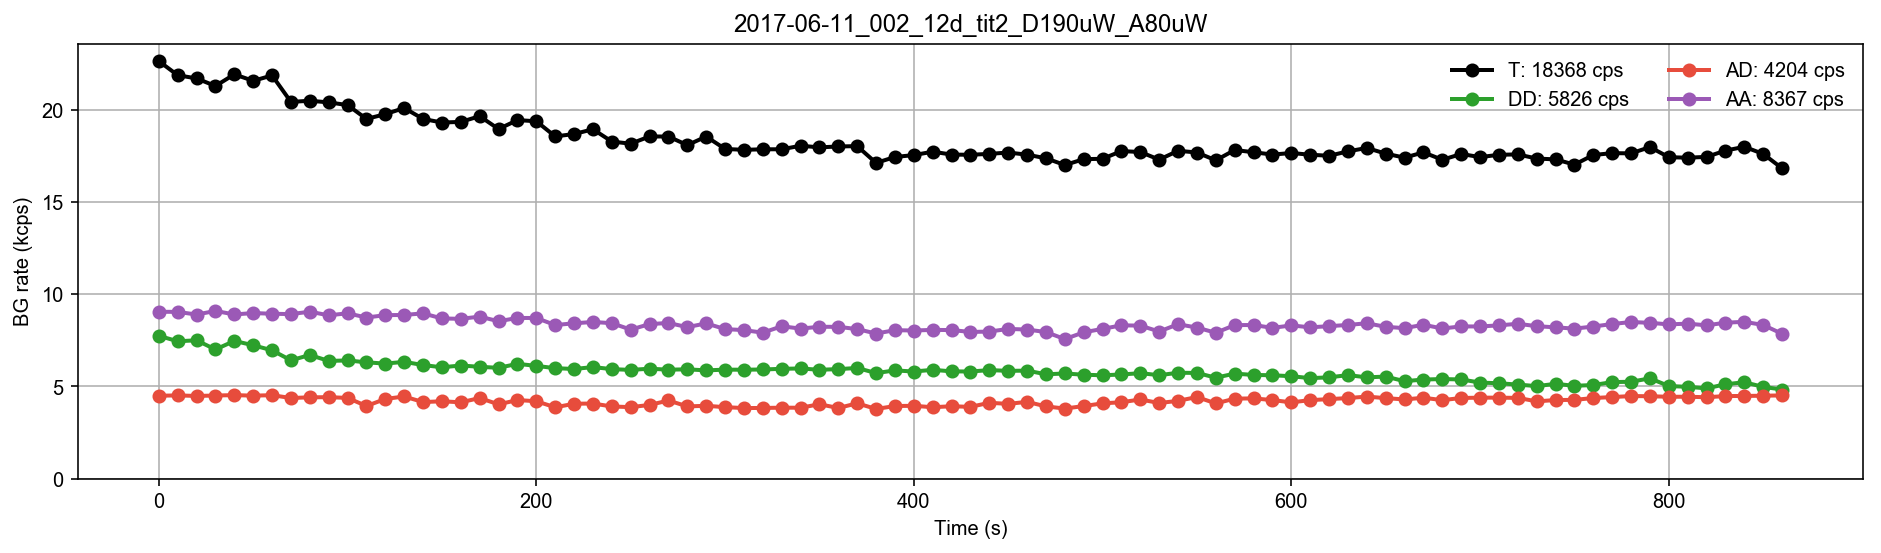

In [23]:
fig, ax = plt.subplots(figsize=(16, 4))
dplot(d, timetrace_bg, ax=ax)

# Burst analysis

In [24]:
d.burst_search(min_rate_cps=50e3)
d = d.select_bursts(select_bursts.time, time_s1=200)
d.num_bursts

 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]


array([342499])

(-27.600000000000001, 500)

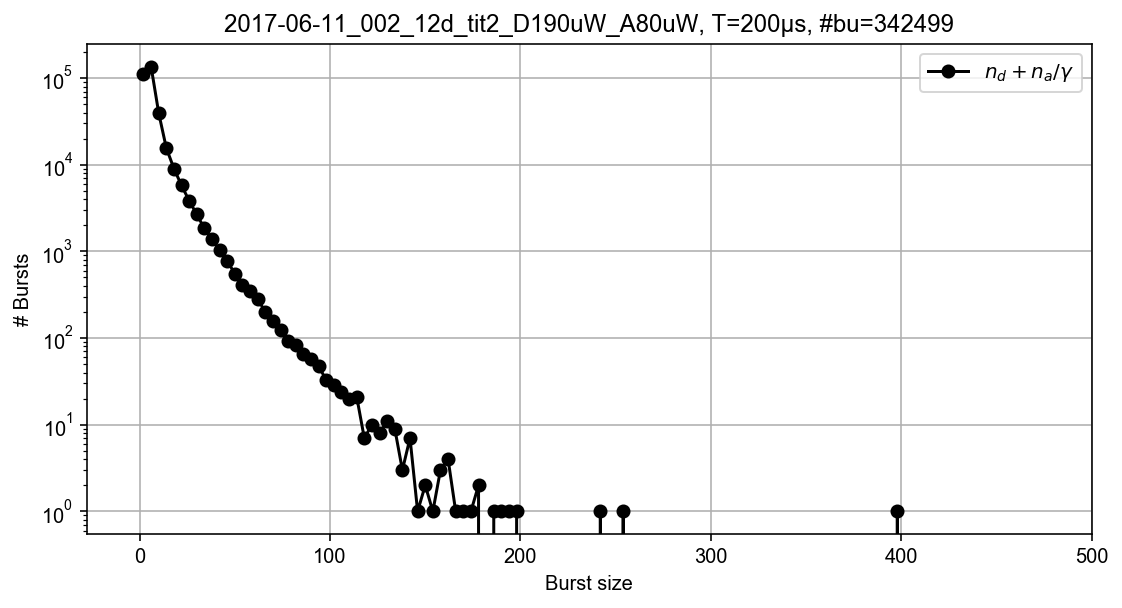

In [25]:
dplot(d, hist_size)
plt.xlim(None, 500)

(0, 10)

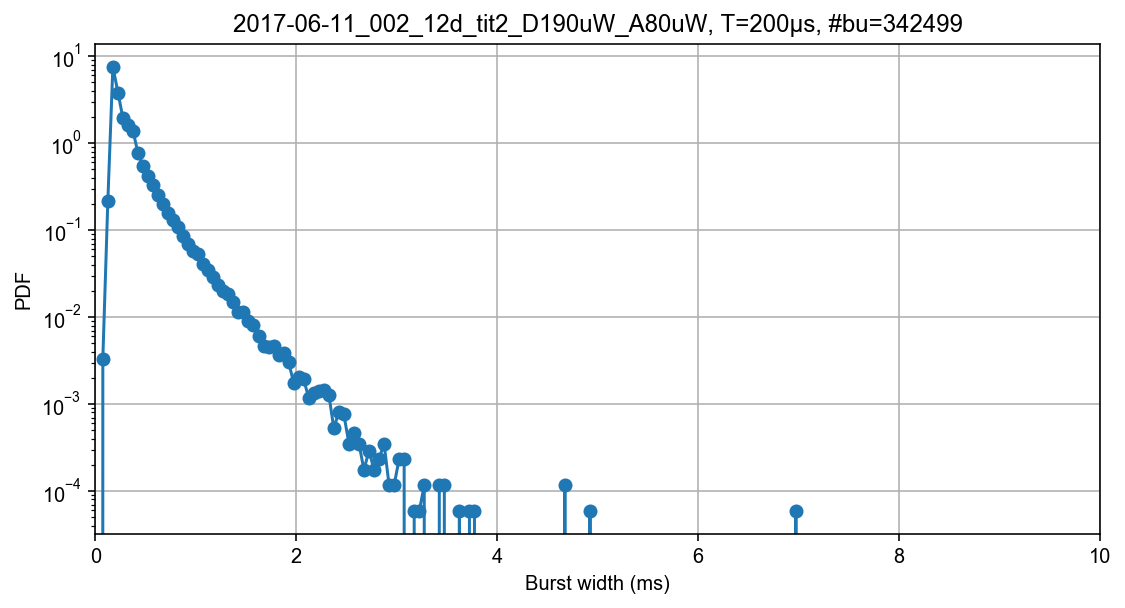

In [26]:
dplot(d, hist_width, bins=(0, 10, 0.05))
plt.xlim(0, 10)

In [27]:
d.calc_max_rate(m=10, ph_sel=Ph_sel(Dex='Dem'), compact=True)

In [28]:
recompute = True
streams = ('DexDem', 'DexAem', 'AexAem')
colors = (bpl.green, bpl.red, bpl.purple)
phrates = {}
for stream in streams:
    print(' - Computing peak photon rates for %6s stream.' % str(Ph_sel.from_str(stream)))
    cal_phrate(d, stream=Ph_sel.from_str(stream), phrates=phrates, recompute=recompute)

 - Computing peak photon rates for DexDem stream.
stream DexDem compact
   Valid fraction (mean of all ch): 13.4 %
 - Computing peak photon rates for DexAem stream.
stream DexAem compact
   Valid fraction (mean of all ch): 8.9 %
 - Computing peak photon rates for AexAem stream.
stream AexAem compact
   Valid fraction (mean of all ch): 23.3 %


In [29]:
phrates[stream]

{'num_bursts': 342499,
 'num_nans': 262693,
 'num_valid': 79806,
 'valid_fraction': 23.301089930189576}

In [30]:
phr_dd = phrates['DexDemB']
phr_dd[0]

0                  NaN
1                  NaN
2                  NaN
3                  NaN
4         52885.869759
              ...     
342494             NaN
342495             NaN
342496             NaN
342497             NaN
342498             NaN
Name: 0, dtype: float64

In [31]:
float(phr_dd.loc[phr_dd[0]>100e3].mean() - 100e3)

85389.3285106869

Saved: figures/2017-06-11_002_12d_usALEX_peak_phrate.png


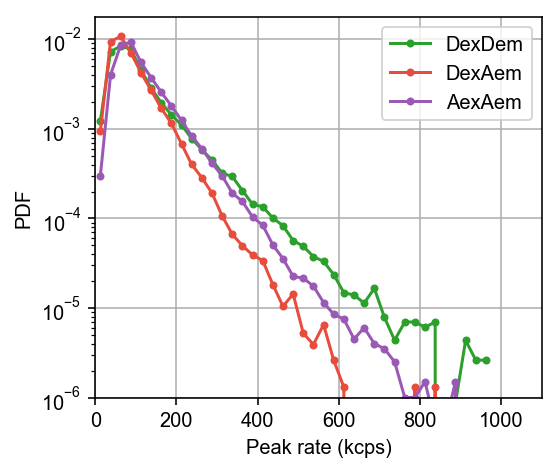

In [32]:
fig, ax = plt.subplots(figsize=(4, 3.5))
bins = (0, 1000, 25)
for stream, color in zip(streams, colors):
    hist_burst_phrate(phrates[stream+'B'], bins=bins, plot_style=dict(color=color, ms=3, label=stream))
plt.xlim(0, 1100)
plt.ylim(1e-6)
plt.title(d.name)
plt.legend()
plt.grid()
plt.title('')
savefig('usALEX_peak_phrate')

In [33]:
d.burst_sizes_ich()

array([ 2.83606608,  3.86595254,  2.88527568, ...,  2.04204755,
        4.95810695,  1.16206276])

In [34]:
ds = d.select_bursts(select_bursts.size, th1=40, gamma=1)

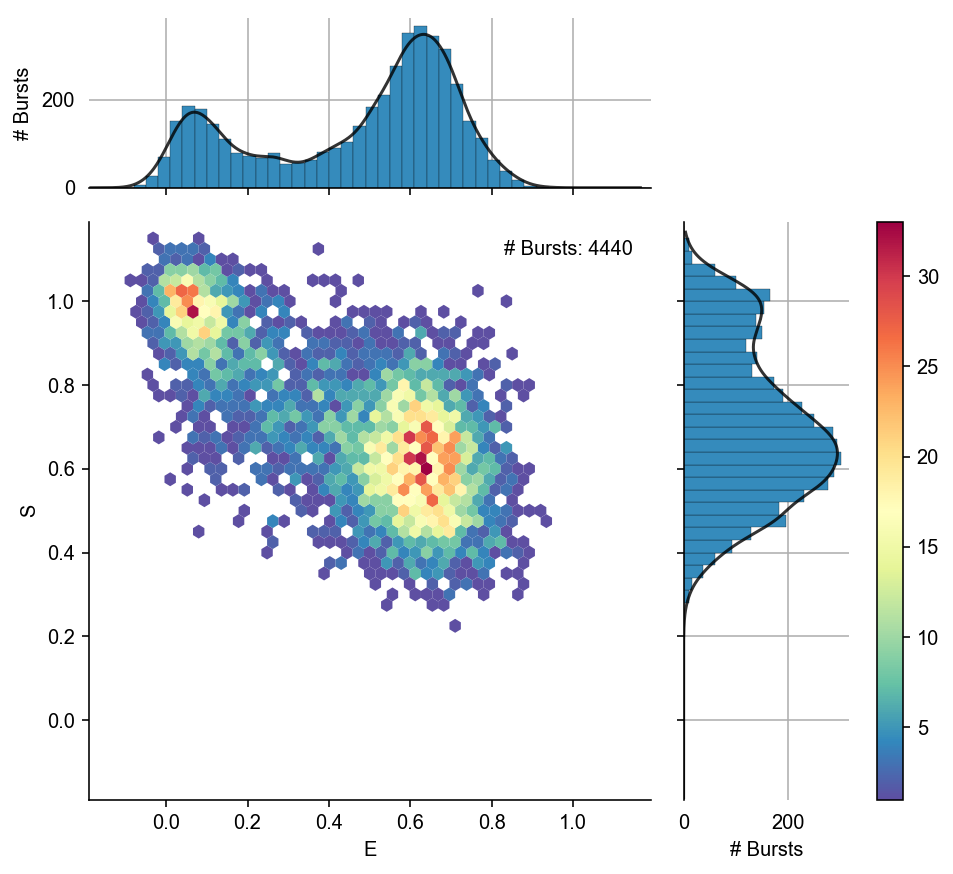

In [35]:
alex_jointplot(ds, vmax_fret=False, vmin=1)

In [36]:
ds1 = d.select_bursts(select_bursts.naa, th1=20)
dss = ds1.select_bursts(select_bursts.size, th1=40)

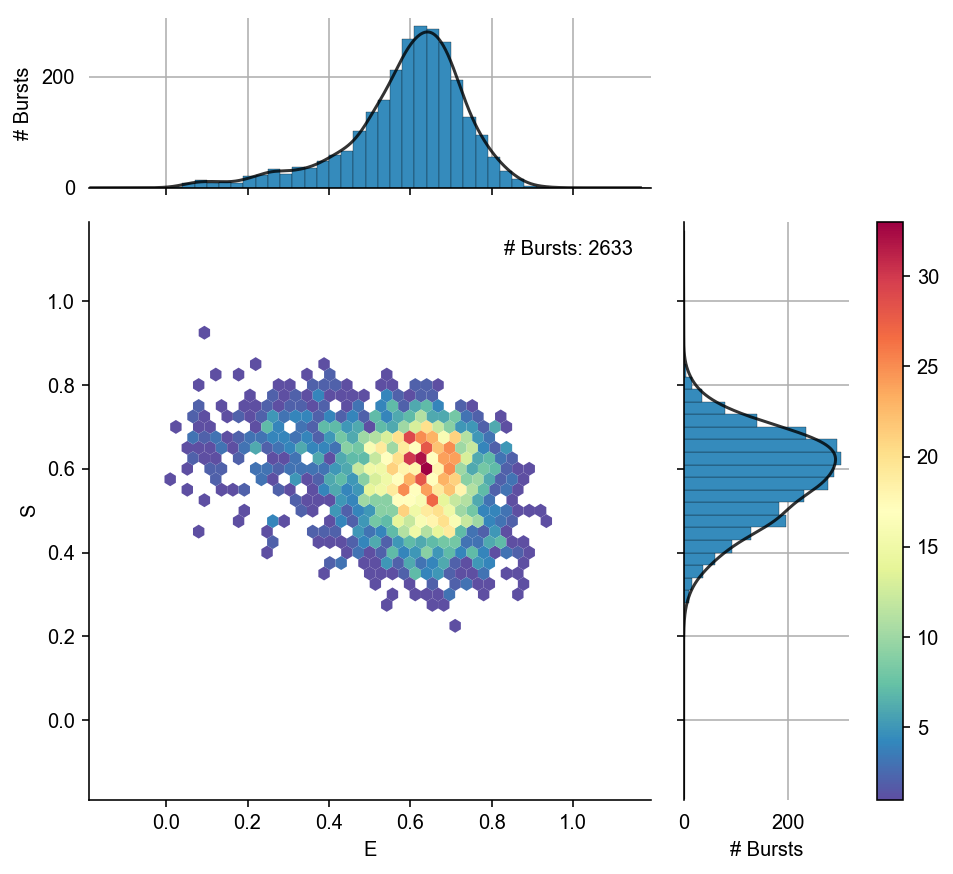

In [37]:
alex_jointplot(dss, vmax_fret=False, vmin=1)

In [38]:
d2 = bext.burst_search_and_gate(d, min_rate_cps=30e3)

Deep copy executed.
Deep copy executed.
Deep copy executed.
 - Performing burst search (verbose=False) ... - Fixing  burst data to refer to ph_times_m ... [DONE]
[DONE]
 - Calculating burst periods ...[DONE]
 - Performing burst search (verbose=False) ... - Fixing  burst data to refer to ph_times_m ... [DONE]
[DONE]
 - Calculating burst periods ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]


In [39]:
ds2 = d2.select_bursts(select_bursts.size, th1=30)

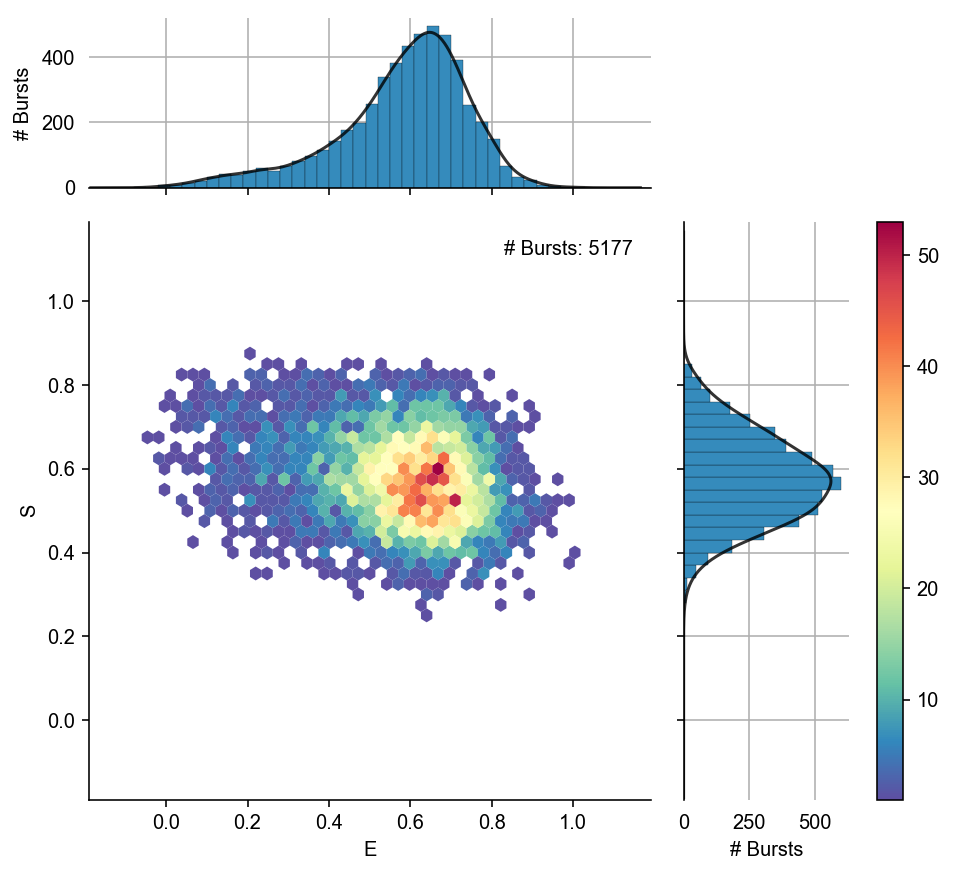

In [40]:
alex_jointplot(ds2, vmax_fret=False, vmin=1)

In [41]:
vals, counts = np.unique(ds.burst_data_ich(0)['bg_period'], return_counts=True)

In [42]:
counts

array([106, 107,  89, 106,  83,  80,  94,  91,  96,  80,  71,  68,  79,
        62,  80,  71,  74,  77,  54,  66,  68,  72,  52,  59,  62,  53,
        61,  61,  58,  59,  67,  51,  53,  62,  67,  66,  49,  58,  55,
        68,  53,  49,  64,  67,  54,  64,  58,  48,  66,  58,  63,  59,
        74,  50,  73,  54,  56,  63,  51,  80,  61,  81,  75,  62,  62,
        59,   1])

(0, 112.3)

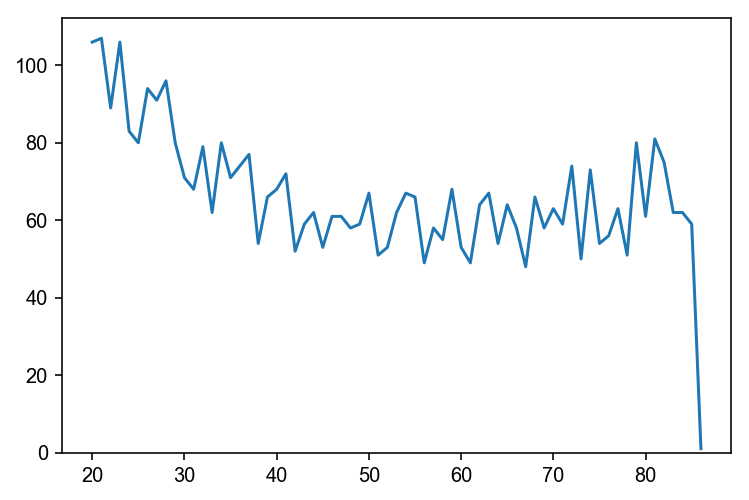

In [43]:
plt.plot(vals, counts)
plt.ylim(0)